In [5]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import datetime
import scipy
from src.config import configurations
from src.dimensionality_reduction import compute_covariance, visualize_manifold_method, choose_dimension
from src.dimensionality_reduction import viz_cluster_map, viz_LLE, viz_Isomap, viz_SE
from src.utils import define_paths, load_data, convert_to_python_dict, save_obj, load_obj, find_closest_time_series
from src.utils import plot_time_series, find_cos_similarity, intersection, relabel_clusters
from src.core_pipeline import analysis, GMM_clustering_R
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
from sklearn.manifold import Isomap, SpectralEmbedding, LocallyLinearEmbedding, trustworthiness
from sklearn.manifold import trustworthiness
from copy import copy 
from kneed import DataGenerator, KneeLocator
import pickle
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import scipy
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
%matplotlib inline
plt.rcParams['figure.dpi'] = 600
matplotlib.rcParams['lines.markersize'] = 4

STATE:  wa
Data loaded. Dropped NaNs shape:(4752, 117). Initial shape:(4764, 117)
##################D-RED#################
Trying n_components=14
Saving optimal embedding. Method:  SpectralEmbedding shape:  (4752, 14)
##################INITIAL VIZ#################
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
##################GMM CLUSTERING#################
fitting ...
  |======================================================================| 100%
Elbow point: 4 components with BIC 878276.2851930624
fitting ...
  |======================================================================| 100%
---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VVV (ellipsoidal, varying volu

/home/levin/code/covid-mobility-and-behavior/src/core_pipeline.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CI['cluster'] = SE_clusters_block_indexed.astype('int')
/home/levin/code/covid-mobility-and-behavior/src/core_pipeline.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CI['block'] = df_CI.index
/home/levin/code/covid-mobility-and-behavior/src/core_pipeline.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

##################FINAL VIZ#################
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
STATE:  ga
Data loaded. Dropped NaNs shape:(5510, 117). Initial shape:(5519, 117)
##################D-RED#################
Trying n_components=14
Saving optimal embedding. Method:  SpectralEmbedding shape:  (5510, 14)
##################INITIAL VIZ#################
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
2D Args: {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
##################GMM CLUSTERING#################
fitting ...
  |======================================================================| 100%
Elbow point: 3 components with BIC 1023435.3816053508
fitting ...
  |======================================================================| 100%
---------------------------------------------------- 
Gaussian finite mixture model fitted b

/home/levin/code/covid-mobility-and-behavior/src/core_pipeline.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CI['cluster'] = SE_clusters_block_indexed.astype('int')
/home/levin/code/covid-mobility-and-behavior/src/core_pipeline.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CI['block'] = df_CI.index
/home/levin/code/covid-mobility-and-behavior/src/core_pipeline.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

##################FINAL VIZ#################
3D Args: {'n_neighbors': 50, 'n_components': 3, 'n_jobs': -1}
STATE:  tx
Data loaded. Dropped NaNs shape:(15719, 117). Initial shape:(15763, 117)
##################D-RED#################
Trying n_components=14


MemoryError: Unable to allocate 1.84 GiB for an array with shape (15719, 15719) and data type int64

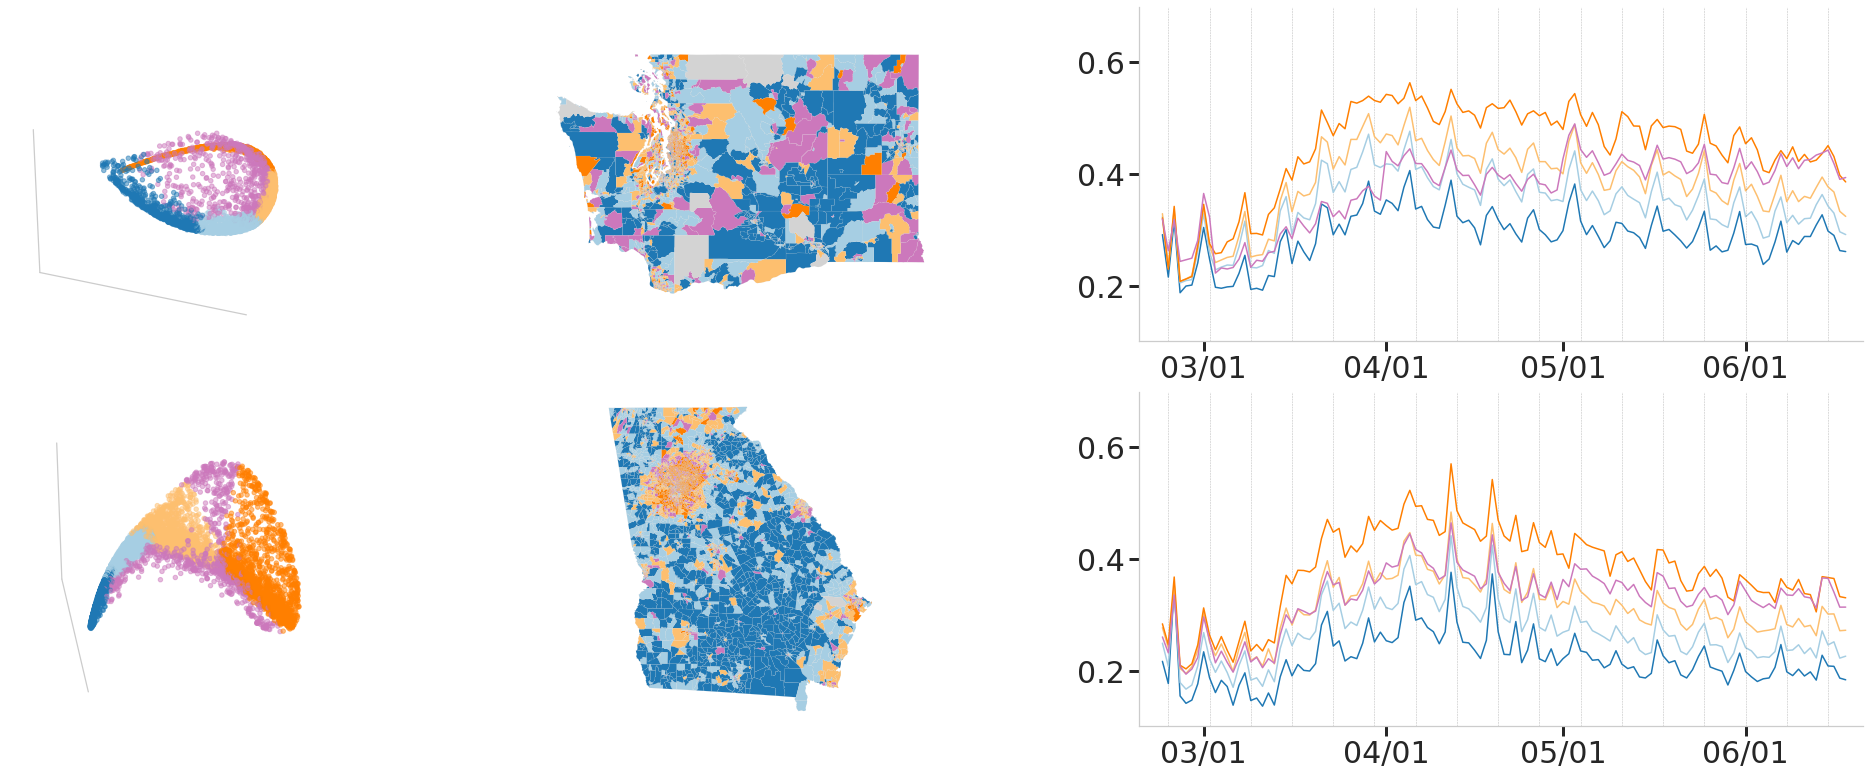

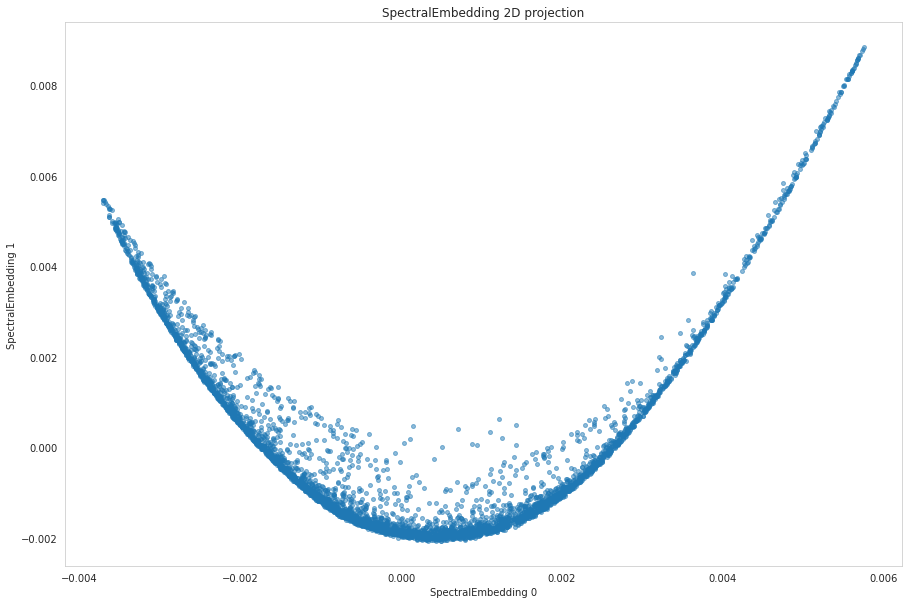

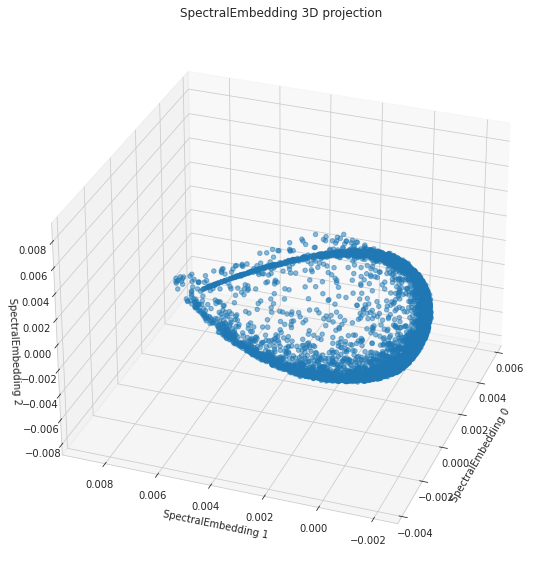

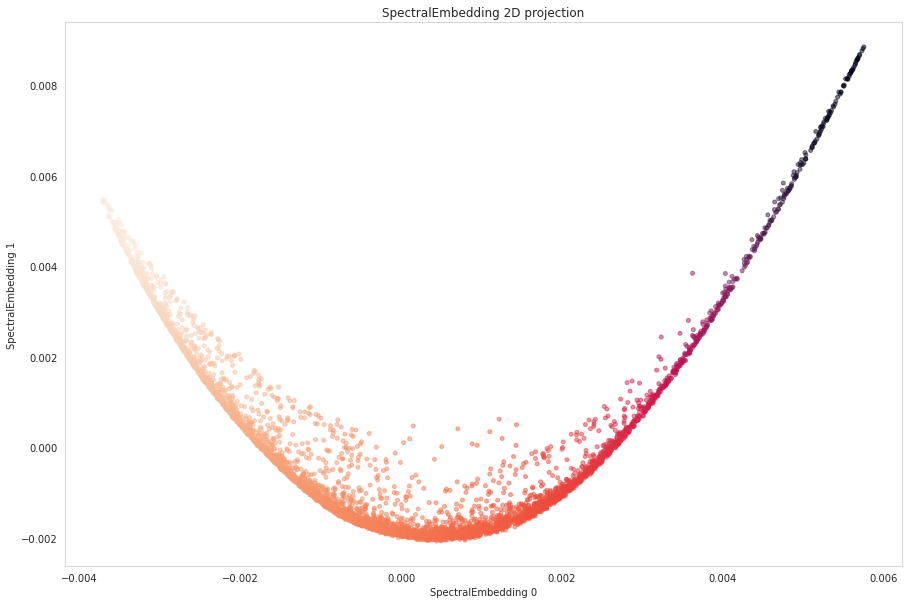

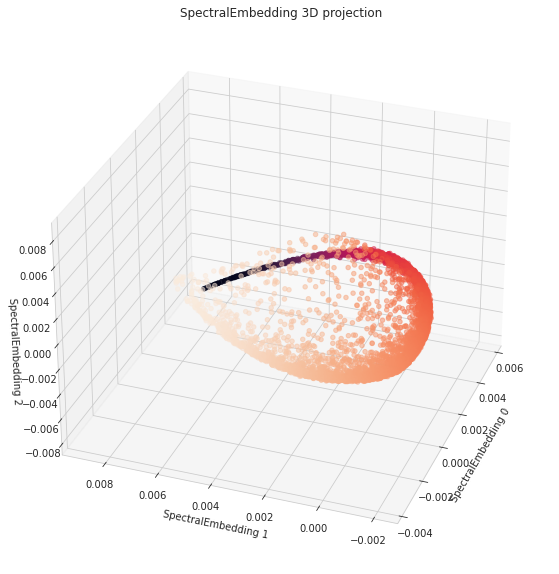

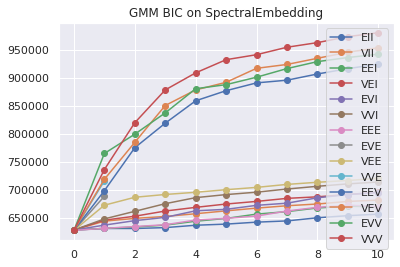

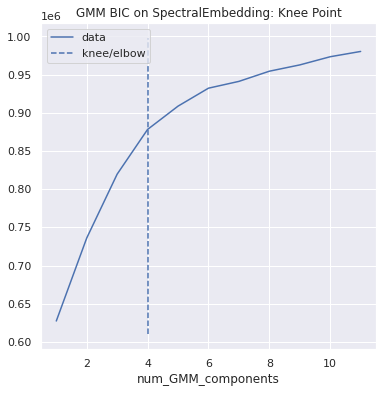

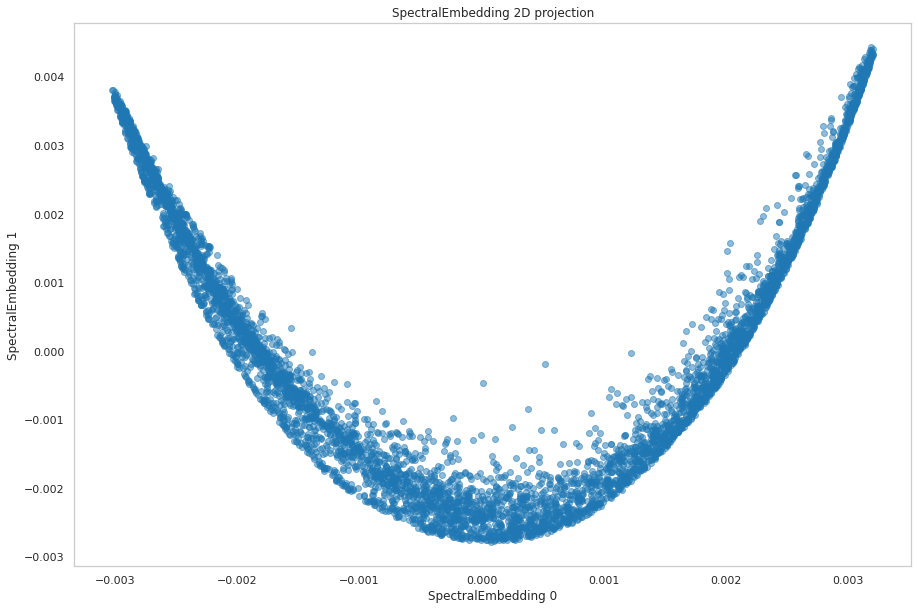

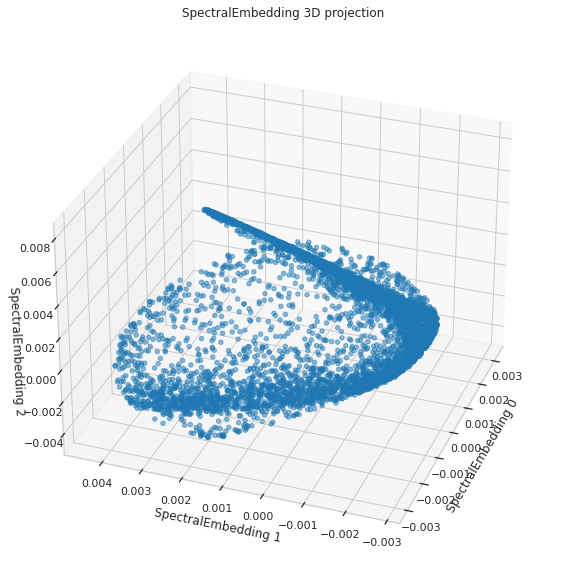

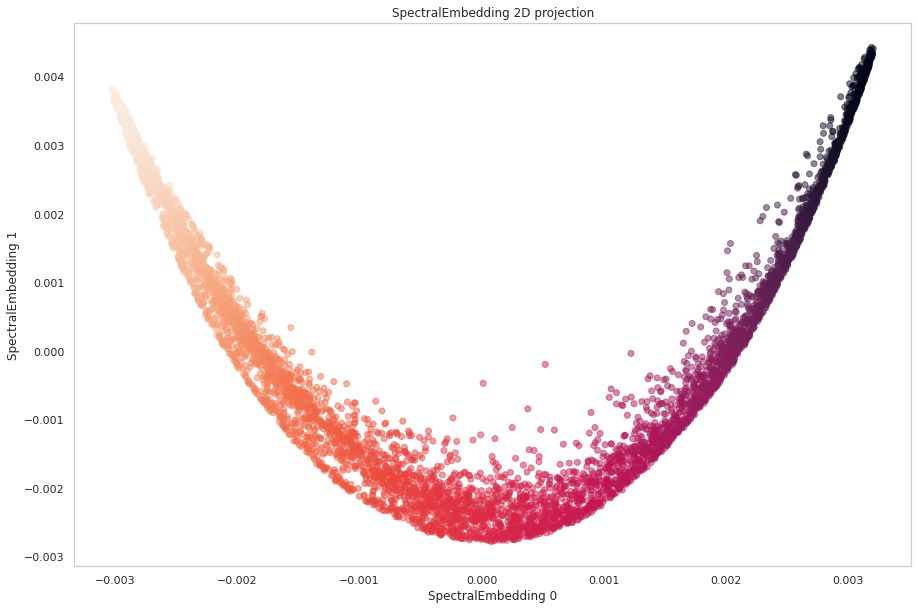

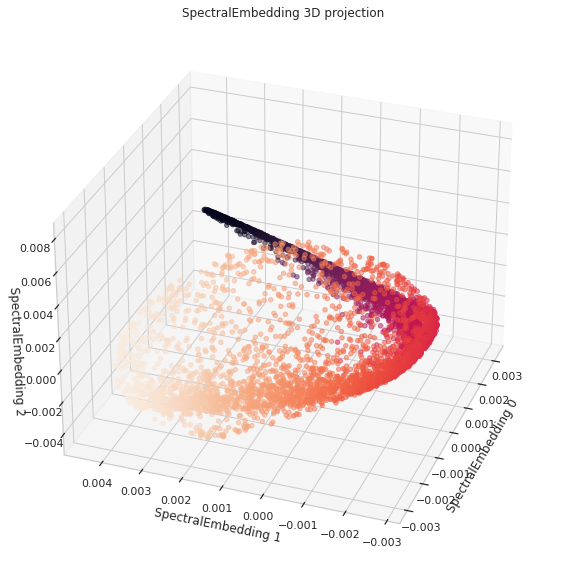

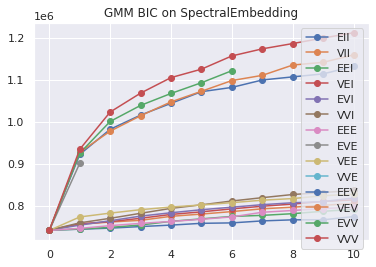

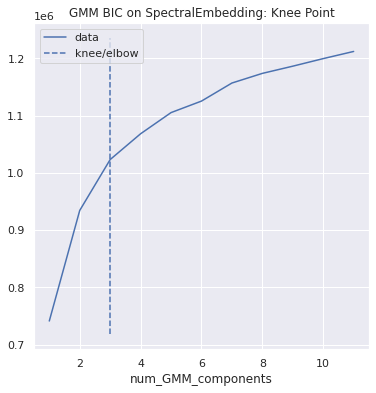

In [2]:
almost_sequential_pal = configurations['clustering_palette']#['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
sns.set_palette(almost_sequential_pal)

method = SpectralEmbedding
hyperparams_to_test = {'n_components': [14]}# np.arange(2, max_components, 2)}
method_kwargs = {'n_neighbors': 50, 'n_components': 2, 'n_jobs': -1}

fig = plt.figure(figsize = (5*7*1.15, 5*(6.25 - 0.77)))

states = ['wa', 'ga', 'tx', 'ca']
NUM_STATES = len(states)
NUM_COLS = 3
spec = gridspec.GridSpec(ncols=NUM_COLS, nrows=NUM_STATES, width_ratios=[1, 1.1, 1], wspace=0.00, hspace=0.15)

for row, state in enumerate(states):
    SHAPE_PATH, FIGURE_PATH, RAW_DATA_PATH, INCOME_POPULATION_PATH = define_paths(state)
    print('STATE: ', state)
    analysis(state, method, method_kwargs, hyperparams_to_test, fig, spec, row, precomputed = False, separate = False, two_cols = False, NUM_STATES = NUM_STATES, configurations = configurations)

plt.tight_layout()

In [3]:
fig.savefig(os.path.join(configurations['FIGURE_PATH'], 'summary_fig_three_cols_after_update.png'), bbox_inches = 'tight', dpi = 300)